## 1. Data Exploration

### Table of Contents <a id='toc'></a>
- [Load the dataset and perform initial checks](#load_dataset)
    - Load dataset
    - Check the size and type of data
    - Check missing values
    - [Summary](#load_dataset_summary) 
- [Split the dataset](#split)
- [Explore](#explore)
    - [Feature histograms and descriptive statistics](#histograms)
    - [Summary](#initial_explore_summary)
    - [Feature correlations](#correlations)
    - [Identify low variance features](#zero_variance)
    - [Cluster visualization](#cluster)
    - [Summary](#explore_summary)

In [1]:
# Import libraries
import numpy as np
import pandas as pd 
import os
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold

from util import plot_heat_map, get_class_distribution, get_high_correlated_features, get_constant_features

%matplotlib inline

### Load the dataset and perform initial checks <a id='load_dataset'></a>

In [2]:
# Load the dataset
PATH = os.path.join('../data', 'creditcard')
df = pd.read_feather(PATH)
df.shape

(284807, 31)

In [3]:
df.head(3)

Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28      Amount  Class  
0 -0.189115  0.133558 -0.021053  149.619995      0  
1  0.125895 -0.008983  0.014724    2.690000      0  
2 -0.139097 -0.055353 -0.059752  378.660004      0  

[3 rows x 31 columns]

In [4]:
# Type and size of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  int32  
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

In [5]:
# Check if there is any missing value
df.isnull().values.any()

False

In [6]:
# Class distribution
class_dict = get_class_distribution(df)
print('Class 0 (normal): %.2f%% (%d examples)' % (class_dict[0] * 100, class_dict[0] * df.shape[0]))
print('Class 1 (fraud): %.2f%% (%d examples)' % (class_dict[1] * 100, class_dict[1] * df.shape[0]))


Class 0 (normal): 99.83% (284315 examples)
Class 1 (fraud): 0.17% (492 examples)



<div class="alert-block alert-info">
<strong>Summary:</strong> <a id='load_dataset_summary'></a><ul>
    <li> There is no missing value.</li>
    <li> There is no categorical attribute.</li>
    <li> Examples are highly skewed towards class 0 (normal transactions). Oversampling will be performed.</li>
    <li> <i>Time</i> (seconds between transactions) will be dropped as it is unlikely to be useful.</li> 
    <li> <i>V1</i> - <i>V28</i> are Principal components. Generally scaling was performed before PCA transformation. After feature exploration, we will decide whether to scale these features.</li>
    <li> <i>Amount</i> should be scaled regardless.</li>
</ul>

</div>

### Split the Dataset <a id='split'></a>

In [7]:
X = df.drop(['Time', 'Class'], axis=1) 
y = df[['Class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

print('Class Distributions: ')
train_dict = get_class_distribution(y_train)
print('Training set: %.4f : %.4f'  % (train_dict[0] , train_dict[1]))

test_dict = get_class_distribution(y_test)
print('Test set: %.4f : %.4f'  % (test_dict[0], test_dict[1]))


Class Distributions: 
Training set: 0.9983 : 0.0017
Test set: 0.9981 : 0.0019


### Feature Exploration <a id='explore'></a>

#### Feature Histogram and Descriptive Statistics <a id='histograms'></a>

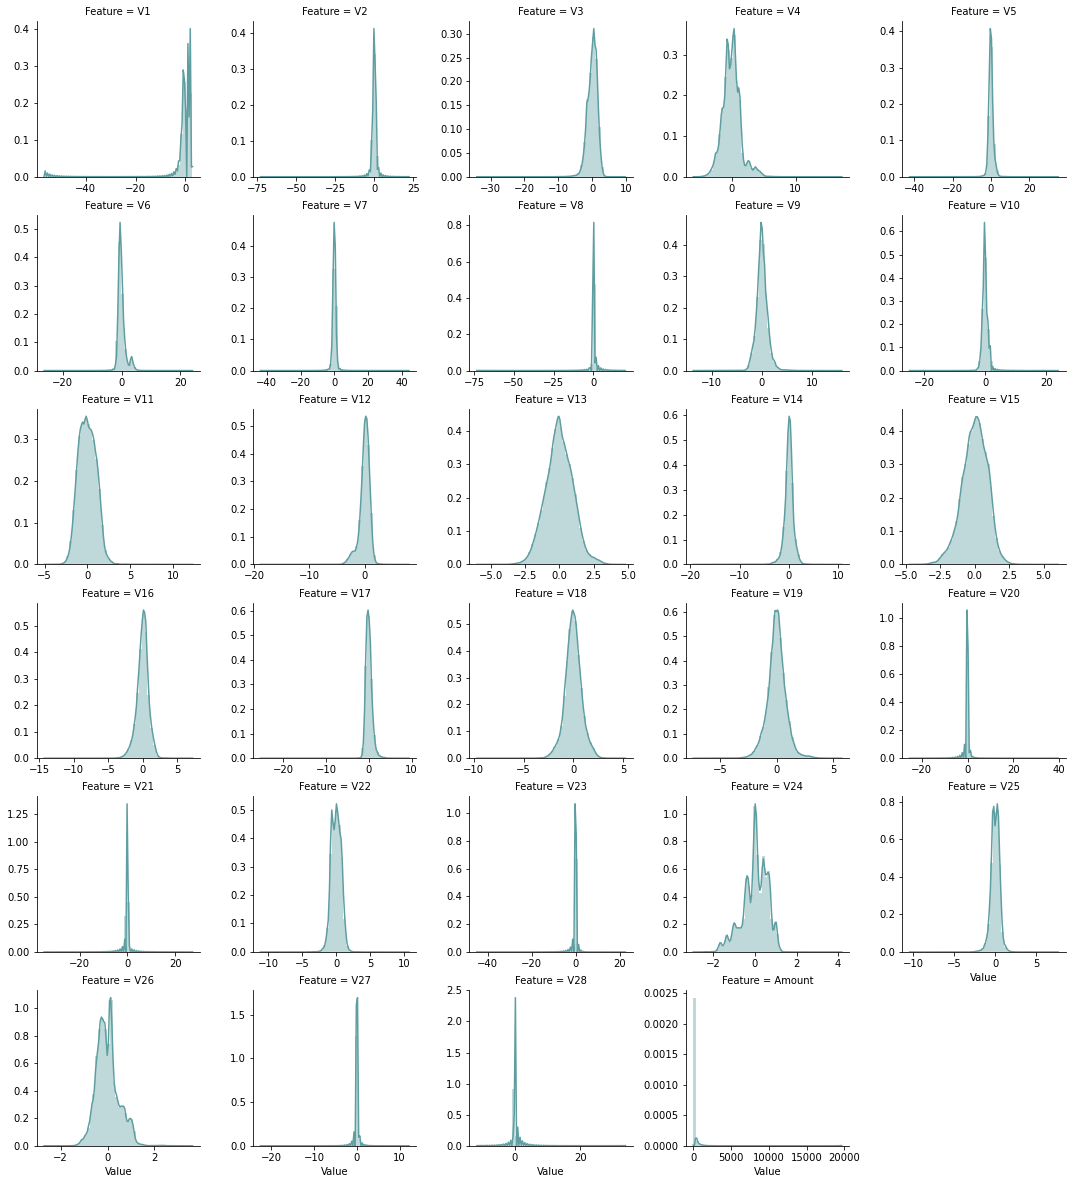

In [8]:
# Grid of histograms
features = X_train.stack().reset_index().rename(columns={'level_1': 'Feature', 0:'Value'})
g = sns.FacetGrid(data=features, col='Feature', col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, 'Value', color='cadetblue')
plt.subplots_adjust(top=0.9)

In [9]:
X_train.describe()

V1             V2             V3             V4  \
count  256326.000000  256326.000000  256326.000000  256326.000000   
mean        0.001553      -0.001070      -0.000134       0.000651   
std         1.957011       1.652916       1.513379       1.416092   
min       -56.407509     -72.715729     -33.680984      -5.683171   
25%        -0.920647      -0.598505      -0.892105      -0.847962   
50%         0.019352       0.064205       0.178350      -0.018514   
75%         1.316077       0.802577       1.027313       0.744182   
max         2.451889      22.057730       9.382559      16.875343   

                  V5             V6             V7             V8  \
count  256326.000000  256326.000000  256326.000000  256326.000000   
mean       -0.001212      -0.000784       0.000780      -0.000598   
std         1.365057       1.326255       1.220855       1.201572   
min       -42.147900     -26.160505     -43.557243     -73.216721   
25%        -0.692641      -0.768613      -0.552665      -0.208742   
50%        -0.055465      -0.274302       0.040395       0.022161   
75%         0.610649       0.398312       0.570231       0.327049   
max        34.801666      23.917837      44.054462      20.007208   

                  V9            V10  ...            V20            V21  \
count  256326.000000  256326.000000  ...  256326.000000  256326.000000   
mean        0.000332       0.000919  ...       0.001485       0.000009   
std         1.099559       1.089847  ...       0.763360       0.733958   
min       -13.434067     -24.588263  ...     -25.222345     -34.830383   
25%        -0.643311      -0.534746  ...      -0.211576      -0.228299   
50%        -0.050516      -0.092162  ...      -0.062470      -0.029104   
75%         0.596979       0.454656  ...       0.133155       0.186995   
max        15.594995      23.745136  ...      39.420906      27.202839   

                 V22            V23            V24            V25  \
count  256326.000000  256326.000000  256326.000000  256326.000000   
mean        0.000711      -0.000177       0.000226       0.000219   
std         0.725754       0.626210       0.605165       0.521587   
min       -10.933144     -44.807735      -2.822684     -10.295397   
25%        -0.542567      -0.161982      -0.354423      -0.317021   
50%         0.007201      -0.011246       0.040881       0.017010   
75%         0.529163       0.147556       0.439439       0.351147   
max        10.503090      22.528412       4.022866       7.519588   

                 V26            V27            V28         Amount  
count  256326.000000  256326.000000  256326.000000  256326.000000  
mean       -0.000030      -0.000707      -0.000058      88.593361  
std         0.482081       0.400282       0.327502     247.087189  
min        -2.604551     -22.565680     -11.710896       0.000000  
25%        -0.327218      -0.070816      -0.052951       5.650000  
50%        -0.052086       0.001190       0.011196      22.000000  
75%         0.240883       0.090650       0.078142      77.489998  
max         3.517346      12.152401      33.847809   19656.529297  

[8 rows x 29 columns]


<div class="alert-block alert-info">
<strong>Summary:</strong> <a id='initial_explore_summary'></a>
<ul>
    <li> The majority of Principal components <i>V1</i> - <i>V28</i> are gaussian centering around zero. Because of this, we assume that scaling was performed before PCA transformation. Scaling will not be performed on these features. </li>
    <li> The majority of transaction amounts (<i>Amount</i>) are small. The average transaction is around 88 and the first 75% of transactions ranging from 0 to around 77. A few large transactions are possible outliers.</li>
</ul>
</div>

#### Attribute Correlations <a id='correlations'></a>
<i>Notes:</i>
<ul>
    <li> <i>Amount</i> will be scaled before correlation analysis. </li>
    <li> Because of imbalanced dataset, random undersampling will be done for accurate correlation analysis. This is only for the purpose of data exploration. Later, oversampling will be performed to prepare the dataset for training.</li>
</ul>

#### Scaling: *Amount*

In [10]:
# RobustScaler is chosen as it is less prone to outliers.
robust_scaler = RobustScaler()

# Scale Amount to sAmount
X_train['sAmount'] = robust_scaler.fit_transform(X_train['Amount'].values.reshape(-1, 1))
# Drop Amount
X_train.drop(['Amount'], axis=1, inplace=True)
print(X_train['sAmount'].describe())
X_train.head()

count    256326.000000
mean          0.926968
std           3.439410
min          -0.306236
25%          -0.227589
50%           0.000000
75%           0.772411
max         273.309143
Name: sAmount, dtype: float64


V1        V2        V3        V4        V5        V6        V7  \
75808   1.164205  0.146269  0.265609  0.542584 -0.251798 -0.308432 -0.184500   
93032   1.239421  0.303304  0.662998  0.691583 -0.588137 -1.166943  0.106462   
234477  2.064223  0.031265 -1.037415  0.407322 -0.050995 -1.193716  0.256999   
228381  0.085616  0.818719 -0.289101 -1.072229  1.302856  0.253538  0.874920   
206051 -1.096178 -0.491427  0.178154 -3.129779  0.394126  1.011264  1.607475   

              V8        V9       V10  ...       V20       V21       V22  \
75808   0.160106 -0.021212 -0.118487  ... -0.184608 -0.222771 -0.718522   
93032  -0.258772 -0.063699 -0.082536  ... -0.069125 -0.229928 -0.636977   
234477 -0.396737  0.377442  0.041977  ... -0.157321 -0.276808 -0.608490   
228381  0.069566 -0.336343 -0.267183  ...  0.080309 -0.277670 -0.664219   
206051  0.114856 -1.733130 -0.848471  ... -0.041625 -0.042483  0.028578   

             V23       V24       V25       V26       V27       V28   sAmount  
75808   0.160307 -0.060052  0.065680  0.111192 -0.019981  0.014698 -0.243736  
93032   0.170835  0.721999  0.193470  0.072508 -0.024726  0.023403 -0.293847  
234477  0.329148  0.075844 -0.262686  0.191859 -0.063488 -0.057684 -0.293847  
228381 -0.044360 -0.341897 -0.335338  0.151365  0.240506  0.084775 -0.243736  
206051  0.099622 -1.396320  0.759856  0.880655 -0.103621  0.015330  3.181097  

[5 rows x 29 columns]

#### Random undersampling

In [11]:
# Both features and target will be used in correlation analysis
Xy_train = pd.concat([X_train, y_train], axis=1)

# Shuffle data
Xy_train = Xy_train.sample(frac=1, random_state=42)

# Count number of fraudulent transactions in training set.
count_fraud = Xy_train['Class'].value_counts()[1]

frauds = Xy_train.loc[Xy_train['Class'] == 1]
# Get the same amount of valid transactions as fraudulent transactions
valids = Xy_train.loc[Xy_train['Class'] == 0][:count_fraud]

# Create undersampled dataframe and shuffle rows
Xy_train_undersampled = pd.concat([frauds, valids]).sample(frac=1, random_state=42)

#### Linear Correlation

['V17']

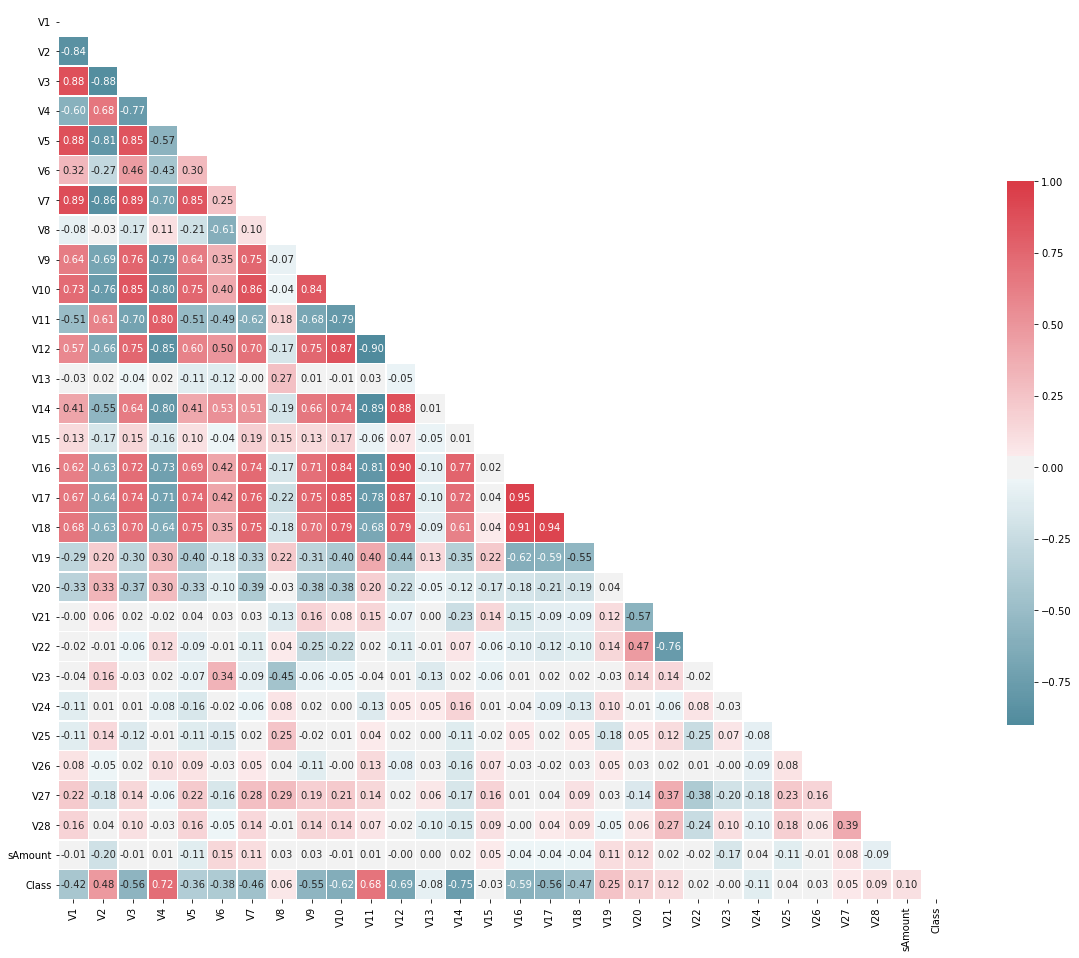

In [12]:
# Correlation plot: Linear relationship
lin_corr = Xy_train_undersampled.corr()
plot_heat_map(lin_corr)
# Obtain high correlated feature(s) to be dropped
drop_list = get_high_correlated_features(lin_corr)
drop_list

#### Non-linear Correlation

In [13]:
# Correlation plot: Monotonic relationship
mono_corr = Xy_train_undersampled.corr(method='spearman')
plot_heat_map(mono_corr)
# Obtain high correlated feature(s) to be dropped
drop_list += get_high_correlated_features(mono_corr)
drop_list

['V17']

#### Zero Variance Feature(s) <a id='zero_variance'></a>

In [14]:
# Obtain unchange feature(s) to be dropped
drop_list += get_constant_features(X_train)
drop_list

['V17']

#### Clustering plot with t-SNE <a id='cluster'></a>
*Note:* Undersampled data will be used for efficiency

In [15]:
X_train_undersampled = Xy_train_undersampled.drop('Class', axis=1)
y_train_undersampled = Xy_train_undersampled['Class']

# Reduce features to 2 dimensions with t-SNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_train_undersampled.values)

In [16]:
# t-SNE object to dataframe with target
Xy_tsne = pd.DataFrame({'X': X_tsne[:, 0], 
                        'Y': X_tsne[:, 1], 
                        'Class': y_train_undersampled.values})
Xy_tsne.head()

X          Y  Class
0 -13.239806   0.159669      0
1  30.728540 -17.584902      1
2  25.010509 -14.759687      1
3 -24.900606  -9.481958      0
4  30.844484  45.172791      1

In [17]:
# Scatter plot of clusters
sns.scatterplot(x='X', y='Y', hue='Class', palette=['cadetblue','indianred'], data=Xy_tsne)
    


<div class="alert-block alert-info">
<strong>Summary:</strong> <a id='explore_summary'></a>
<ul>
    <li> <i>V17</i> should be dropped as it is highly correlated with another feature(s). </li>
    <li> t-SNE algorithm is able to show clear separation between fraudulent and valid transactions. This indicates viable pattern in the dataset.</li>
</ul>
</div>